<a href="https://colab.research.google.com/github/JSybrandt/tutorials/blob/master/one_off/machine_learning_crash_course.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports

In [0]:

# imports for the whole notebook
import numpy as np
import scipy as sp
from sklearn.cluster import KMeans
from IPython.display import Image, display
from google.colab import files
import cv2
from matplotlib import pyplot as plt
from sklearn.datasets import load_boston
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, classification_report
from pprint import pprint
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.datasets import load_digits
from sklearn.utils import shuffle
from random import random, randint

# Clustering

In the following cells we go over an application of K-Means clustering for image compression.

First, we read in an image.
Then, we convert it to a set of points in 3 dimensions (R, G, B).
By applying K-Means to this set, we group pixels into similar clusters.
Finally, we output an image where each original pixel is replaced with its corresponding centroid.


In [0]:
for path in files.upload():
  img_path = path
  break

Saving apple.jpg to apple.jpg


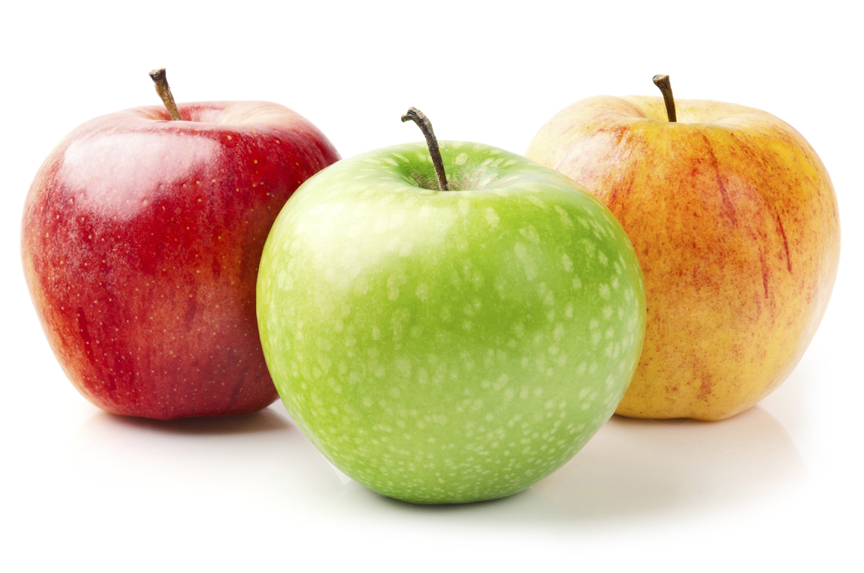

In [0]:
# input image
img_display_size = 300
Image(img_path, width=img_display_size)

In [0]:
num_clusters = 20 #@param {type:"integer"}

In [0]:
# Load image data as an n by m by 3 matrix
pixels = cv2.imread(img_path)
original_shape = pixels.shape

# Reshape into a (nXm) by 3 matrix
# Each row is an "example"
pixels = pixels.reshape(-1, 3)


print("Input image contains {}x{} pixels".format(original_shape[0],
                                                 original_shape[1]))
print("and {} distinct colors!".format(len(set([tuple(p) for p in pixels]))))

Input image contains 573x864 pixels
and 91485 distinct colors!


In [0]:
# Perform clustering
kmeans = KMeans(num_clusters).fit(pixels)


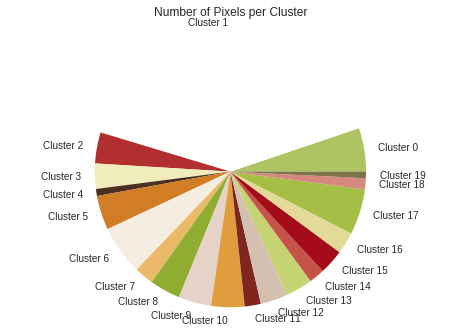

In [0]:
# Show cluster information
labels = ["Cluster {}".format(i) for i in range(num_clusters)]
values = [sum([1 for i in kmeans.labels_ if i == cluster])
          for cluster in range(num_clusters)]
colors = [ list(reversed(c/255)) for c in kmeans.cluster_centers_ ]

plt.pie(values, labels=labels, colors=colors)
plt.axis('equal')
plt.title("Number of Pixels per Cluster")
plt.show()

In [0]:
# Replace points with cluster centers
for cluster_idx, pixel_idx in zip(kmeans.labels_, range(pixels.shape[0])):
    pixels[pixel_idx] = kmeans.cluster_centers_[cluster_idx]

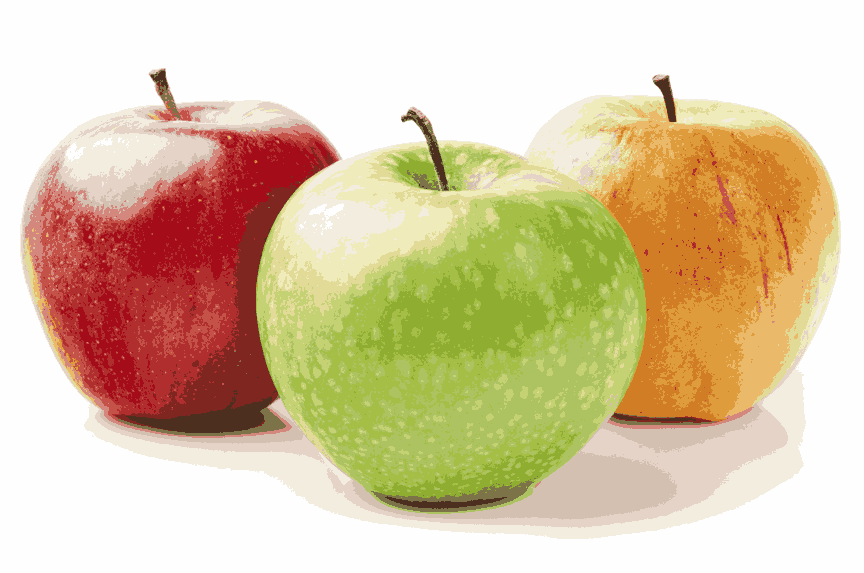

In [0]:
new_img = pixels.reshape(original_shape)
cv2.imwrite("compressed.png", new_img)
Image("compressed.png", width=img_display_size)

# Regression

In this example we are going to estimate house prices, and go over some simple regression techniques.

This uses the boston house dataset. More information can be found [here](https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.names)

In [0]:
# Load data
dataset = load_boston()
idx2feature = dataset['feature_names']
feature2idx = {feat_name: idx 
               for idx, feat_name 
               in enumerate(dataset['feature_names'])}
examples = dataset['data']
targets = dataset['target']
num_features = len(feature2idx)

print("Features:", " ".join(dataset['feature_names']))
print("Loaded boston house data,",
      "with {} examples and {} features".format(len(examples),
                                                num_features))

Features: CRIM ZN INDUS CHAS NOX RM AGE DIS RAD TAX PTRATIO B LSTAT
Loaded boston house data, with 506 examples and 13 features


## Explore data

Input one of the feature names (listed in above output) to see correlations.

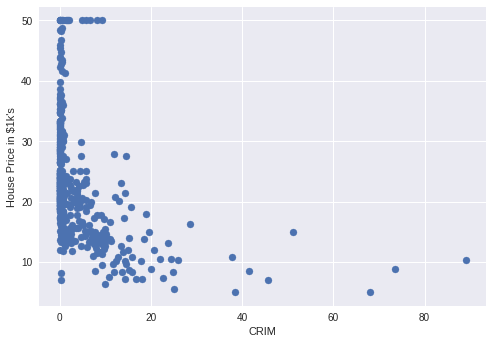

In [0]:
# study the effect of one parameter on housing prices
feature_name = "CRIM" # @param {type: "string"}
plt.scatter(examples[:, feature2idx[feature_name]], targets)
plt.xlabel(feature_name)
plt.ylabel("House Price in $1k's")
plt.show()

### Feature Ranges

Note that each feaure spans a different range. Most models struggle to converge given these different distributions.

In [0]:
# This helper function lets us peek at the data table
def to_range_table(data):
  return pd.DataFrame({"Feature": [idx2feature[i] for i in range(num_features)],
                      "Min": [min(data[:, i]) for i in range(num_features)],
                      "Max": [max(data[:, i]) for i in range(num_features)],
                      "Range": [max(data[:, i]) - min(data[:, i])
                             for i in range(num_features)]},
                 columns=["Feature", "Min", "Max", "Range"])

def to_value_table(example):
   return pd.DataFrame({"Feature": [idx2feature[i] for i in range(num_features)],
                      "Value": example},
                 columns=["Feature", "Value"])

In [0]:
print("Before normalization")
to_range_table(examples)

Before normalization


,Feature,Min,Max,Range
0,CRIM,0.00632,88.9762,88.96988
1,ZN,0.00000,100.0000,100.00000
2,INDUS,0.46000,27.7400,27.28000
3,CHAS,0.00000,1.0000,1.00000
4,NOX,0.38500,0.8710,0.48600
5,RM,3.56100,8.7800,5.21900
6,AGE,2.90000,100.0000,97.10000
7,DIS,1.12960,12.1265,10.99690
8,RAD,1.00000,24.0000,23.00000
9,TAX,187.00000,711.0000,524.00000


## Linear Model

We're going to start with a simple linear model. First thing first, split your data into train / test sets. We learn on the training set and evaluate ourselves on the test set.

Note that this solution performs well and is interpretable.
Also note that this is a very small dataset.

In [0]:
X_train, X_test, y_train, y_test = train_test_split(examples,
                                                    targets,
                                                    test_size=0.2)

In [0]:
# From here until the model is trained, we aren't going to touch the test set!

scaler = MinMaxScaler()
print("Training set ranges after normalization")
X_train_normalized = scaler.fit_transform(X_train)
to_range_table(X_train_normalized)

Training set ranges after normalization


,Feature,Min,Max,Range
0,CRIM,0.0,1.0,1.0
1,ZN,0.0,1.0,1.0
2,INDUS,0.0,1.0,1.0
3,CHAS,0.0,1.0,1.0
4,NOX,0.0,1.0,1.0
5,RM,0.0,1.0,1.0
6,AGE,0.0,1.0,1.0
7,DIS,0.0,1.0,1.0
8,RAD,0.0,1.0,1.0
9,TAX,0.0,1.0,1.0


In [0]:
# Train linear model!
regressor = LinearRegression().fit(X_train_normalized, y_train)

In [0]:
# Evaluate targets!
y_train_predictions = regressor.predict(X_train_normalized)

x_test_normalized = scaler.transform(X_test)
y_test_predictions = regressor.predict(x_test_normalized)

print("Training set MSE:", mean_squared_error(y_train_predictions, y_train))
print("Test set MSE:", mean_squared_error(y_test_predictions, y_test))

print("Feature coefficients:")
to_value_table(regressor.coef_)


Training set MSE: 22.981849352301605
Test set MSE: 18.955560518837576
Feature coefficients:


,Feature,Value
0,CRIM,-9.934024
1,ZN,5.083466
2,INDUS,0.635647
3,CHAS,3.282463
4,NOX,-9.630096
5,RM,14.968678
6,AGE,0.968560
7,DIS,-14.898464
8,RAD,7.638631
9,TAX,-7.150413


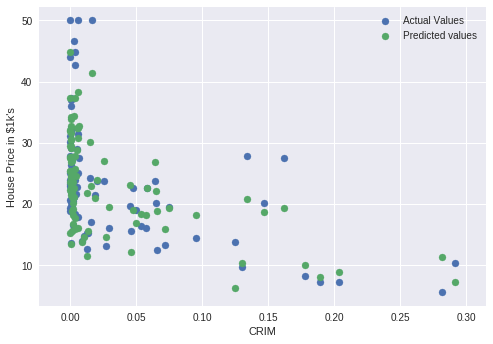

In [0]:
# View the prediction
# study the effect of one parameter on housing prices
feature_name = "CRIM" # @param {type: "string"}
feat_idx = feature2idx[feature_name]
plt.scatter(x_test_normalized[:, feat_idx],
            y_test,
            label="Actual Values")
plt.scatter(x_test_normalized[:, feat_idx],
            y_test_predictions,
            label="Predicted values")
plt.xlabel(feature_name)
plt.ylabel("House Price in $1k's")
plt.legend()
plt.show()

## Nearest - Neighbor Regression 

Can we do better?

Select the # of neighbors to see the relationship between bias and variance.

Note that this solution overfits

In [0]:
num_neighbors = 4 # @param
regressor = KNeighborsRegressor(num_neighbors)
regressor.fit(X_train_normalized, y_train)

# Evaluate targets!
y_train_predictions = regressor.predict(X_train_normalized)
y_test_predictions = regressor.predict(x_test_normalized)

print("Training set MSE:",
      mean_squared_error(y_train_predictions,
                         y_train))
print("Test set MSE:",
      mean_squared_error(y_test_predictions,
                         y_test))

Training set MSE: 11.50664603960396
Test set MSE: 21.470631127450986


## Neural Network Regression

In this case, we don't have enough data. See how a neural network isn't the right solution for this problem!

Note that this solution fails to converge.

In [0]:
hidden_layer_size = 24 # @param
regressor = MLPRegressor([hidden_layer_size],
                         max_iter=10000)
regressor.fit(X_train_normalized, y_train)

# Evaluate targets!
y_train_predictions = regressor.predict(X_train_normalized)
y_test_predictions = regressor.predict(x_test_normalized)

print("Training set MSE:",
      mean_squared_error(y_train_predictions,
                         y_train))
print("Test set MSE:",
      mean_squared_error(y_test_predictions,
                         y_test))

Training set MSE: 46.90362287178945
Test set MSE: 40.382854141554105


# Classification

In this example we are going to detect handwritten digits

In [0]:
# Load data
dataset = load_digits()
examples = dataset['data']
labels = dataset['target']
label_names = dataset['target_names']
images = dataset['images']

examples, labels = shuffle(examples, labels)
num_examples, num_features = examples.shape
examples_per_class = {i: len([1for l in labels if l == i])
                      for i in label_names}

print("Loaded {} images consisting of {} pixels each.".format(num_examples,
                                                              num_features))

Loaded 1797 images consisting of 64 pixels each.


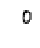

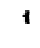

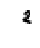

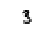

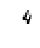

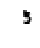

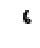

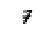

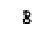

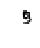

In [0]:
# Look at some specific values
def show_image(img):
  fig = plt.figure(figsize=(.25,.25))
  plt.axis("off")
  plt.imshow(img, cmap=plt.cm.gray_r, interpolation='nearest')
  plt.show()
  
for i in range(10):
  show_image(images[i])

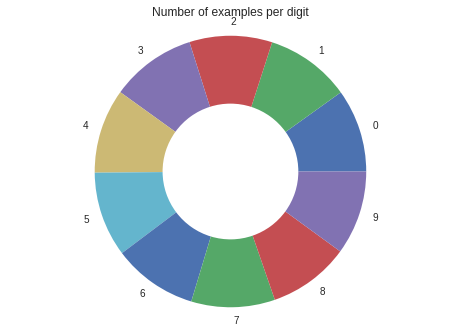

In [0]:
# Check the balance of our classes
plt.pie([examples_per_class[i] for i in label_names],
        labels=label_names,
        wedgeprops=dict(width=0.5))
plt.axis('equal')
plt.title("Number of examples per digit")
plt.show()

In [0]:
# Split off our test set!
X_train, X_test, y_train, y_test = train_test_split(examples,
                                                    labels,
                                                    test_size=0.2)

In [0]:
num_hidden_neurons = (12, 12 ) # @param
classifier = MLPClassifier(
    hidden_layer_sizes=num_hidden_neurons).fit(
    X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [0]:
# Evaluate targets!
y_train_predictions = classifier.predict(X_train)
y_test_predictions = classifier.predict(X_test)

print("Training set:")
print(classification_report(y_train, y_train_predictions))

print("Test set:")
print(classification_report(y_test, y_test_predictions))

Training set:
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       147
          1       0.99      1.00      0.99       148
          2       1.00      1.00      1.00       136
          3       1.00      1.00      1.00       148
          4       1.00      1.00      1.00       146
          5       1.00      0.99      0.99       149
          6       0.99      0.99      0.99       144
          7       1.00      1.00      1.00       130
          8       0.99      0.96      0.98       143
          9       0.97      1.00      0.99       146

avg / total       0.99      0.99      0.99      1437

Test set:
             precision    recall  f1-score   support

          0       1.00      0.97      0.98        31
          1       0.88      0.85      0.87        34
          2       0.97      0.95      0.96        41
          3       0.94      0.97      0.96        35
          4       0.94      0.91      0.93        35
          5       

The following is 7 but we thought it was 9


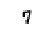

The following is 4 but we thought it was 5


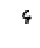

The following is 9 but we thought it was 5


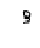

The following is 0 but we thought it was 4


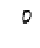

The following is 1 but we thought it was 8


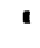

In [0]:
num_to_show = 5 # @param
for img_data, true_label, predicted_label in zip(X_test,
                                                 y_test,
                                                 y_test_predictions):
  if true_label != predicted_label:
    print("The following is",
          "{} but we thought it was {}".format(true_label,
                                               predicted_label))
    show_image(img_data.reshape(8,8))
    num_to_show -= 1
    if num_to_show == 0:
      break